# deterministic autoencoder and variational autoencoder on CelebA

It also uses pre-trained checkpoints, to make the demo faster.
However, the code to train the model from scratch is also included.

In [1]:
from functools import partial
from itertools import islice
import subprocess
from typing import Sequence, Tuple

import flax
import flax.linen as nn
from flax.training import checkpoints, train_state
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import tensorflow as tf

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch import Generator
from torchvision.datasets import MNIST, CelebA

tf.config.set_visible_devices([], "GPU")  # prevent TensorFlow from using the GPU


2024-08-11 10:21:05.721966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 10:21:05.753154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 10:21:05.762321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 10:21:06.305728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1723342868.261924    5857 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

The encoder has convolutional layers followed by a fully connected layer.
The covolutional layers are shared between mean and variance, while each has its own fully connected layer.

In [2]:
class Encoder(nn.Module):
    latent_dim: int
    hidden_channels: Sequence[int]

    @nn.compact
    def __call__(self, X, training):
        for channel in self.hidden_channels:
            X = nn.Conv(channel, (3, 3), strides=2, padding=1)(X)
            X = nn.BatchNorm(use_running_average=not training)(X)
            X = jax.nn.relu(X)

        X = X.reshape((-1, np.prod(X.shape[-3:])))
        mu = nn.Dense(self.latent_dim)(X)
        logvar = nn.Dense(self.latent_dim)(X)

        return mu, logvar



In [3]:

class Decoder(nn.Module):
    output_dim: Tuple[int, int, int]
    hidden_channels: Sequence[int]

    @nn.compact
    def __call__(self, X, training):
        H, W, C = self.output_dim

        # TODO: relax this restriction
        factor = 2 ** len(self.hidden_channels)
        assert (
            H % factor == W % factor == 0
        ), f"output_dim must be a multiple of {factor}"
        H, W = H // factor, W // factor

        X = nn.Dense(H * W * self.hidden_channels[-1])(X)
        X = jax.nn.relu(X)
        X = X.reshape((-1, H, W, self.hidden_channels[-1]))

        for hidden_channel in reversed(self.hidden_channels[:-1]):
            X = nn.ConvTranspose(
                hidden_channel, (3, 3), strides=(2, 2), padding=((1, 2), (1, 2))
            )(X)
            X = nn.BatchNorm(use_running_average=not training)(X)
            X = jax.nn.relu(X)

        X = nn.ConvTranspose(C, (3, 3), strides=(2, 2), padding=((1, 2), (1, 2)))(X)
        X = jax.nn.sigmoid(X)

        return X



In [4]:

def reparameterize(key, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = jax.random.normal(key, logvar.shape)
    return mean + eps * std



In [5]:

class VAE(nn.Module):
    variational: bool
    latent_dim: int
    output_dim: Tuple[int, int, int]
    hidden_channels: Sequence[int]

    def setup(self):
        self.encoder = Encoder(self.latent_dim, self.hidden_channels)
        self.decoder = Decoder(self.output_dim, self.hidden_channels)

    def __call__(self, key, X, training):
        mean, logvar = self.encoder(X, training)
        if self.variational:
            Z = reparameterize(key, mean, logvar)
        else:
            Z = mean

        recon = self.decoder(Z, training)
        return recon, mean, logvar

    def decode(self, Z, training):
        return self.decoder(Z, training)

In [6]:

class TrainState(train_state.TrainState):
    batch_stats: flax.core.FrozenDict[str, jnp.ndarray]
    beta: float


def create_train_state(
    key, variational, beta, latent_dim, hidden_channels, learning_rate, specimen
):
    vae = VAE(variational, latent_dim, specimen.shape, hidden_channels)
    key_dummy = jax.random.PRNGKey(42)
    (recon, _, _), variables = vae.init_with_output(key, key_dummy, specimen, True)
    assert (
        recon.shape[-3:] == specimen.shape
    ), f"{recon.shape} = recon.shape != specimen.shape = {specimen.shape}"
    tx = optax.adam(learning_rate)
    state = TrainState.create(
        apply_fn=vae.apply,
        params=variables["params"],
        tx=tx,
        batch_stats=variables["batch_stats"],
        beta=beta,
    )

    return state


In [7]:
@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))



In [8]:

@jax.jit
def train_step(state, key, image):
    @partial(jax.value_and_grad, has_aux=True)
    def loss_fn(params):
        variables = {"params": params, "batch_stats": state.batch_stats}
        (recon, mean, logvar), new_model_state = state.apply_fn(
            variables, key, image, True, mutable=["batch_stats"]
        )
        loss = jnp.sum((recon - image) ** 2) + state.beta * jnp.sum(
            kl_divergence(mean, logvar)
        )
        return loss.sum(), new_model_state

    (loss, new_model_state), grads = loss_fn(state.params)

    state = state.apply_gradients(
        grads=grads, batch_stats=new_model_state["batch_stats"]
    )

    return state, loss


In [9]:


@jax.jit
def test_step(state, key, image):
    variables = {"params": state.params, "batch_stats": state.batch_stats}
    recon, mean, logvar = state.apply_fn(variables, key, image, False)

    return recon, mean, logvar


In [10]:


@jax.jit
def decode(state, Z):
    variables = {"params": state.params, "batch_stats": state.batch_stats}
    decoded = state.apply_fn(variables, Z, False, method=VAE.decode)

    return decoded



## Download dataset

In [11]:
transform = T.Compose([T.RandomHorizontalFlip(), T.CenterCrop((128, 128)), T.Resize((64, 64)), np.array])

celeba_train = CelebA("data/vae/celeba", split="train", download=True, transform=transform)
celeba_test = CelebA("data/vae/celeba", split="test", download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


## Hyperparameters

In [12]:
import os
ckpt_dir = os.path.abspath("data/vae/ckpts")

epochs = 5
batch_size = 256
latent_dim = 256
hidden_channels = (32, 64, 128, 256, 512)
lr = 1e-3
specimen = jnp.empty((64, 64, 3))

configs = {
    "ae": (False, 0),
    "vae_0.1": (True, 0.1),
    "vae_0.5": (True, 0.5),
    "vae_1.0": (True, 1),
}

2024-08-11 10:21:16.994757: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Prepare checkpoints

Either by downloading or training

In [13]:
def train(name, variational, beta, loader_train, target_epoch):
    print(f"=== Training {name} ===")
    key = jax.random.PRNGKey(42)
    state = create_train_state(key, variational, beta, latent_dim, hidden_channels, lr, specimen)

    for epoch in range(target_epoch):
        loss_train = 0
        for X, _ in loader_train:
            image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0
            key, key_Z = jax.random.split(key)
            state, loss = train_step(state, key_Z, image)
            loss_train += loss

        print(f"Epoch {epoch + 1}: train loss {loss_train}")

        # Keep the model with lowest loss_train
        checkpoints.save_checkpoint(
            ckpt_dir, state, epoch + 1, prefix=f"{name}_celeba_", keep=target_epoch, overwrite=True
        )


def prepare_checkpoints(target_epoch, download=True):
    # Download pre-trained checkpoints by default to save time. At the time
    # of writing, we have prepared the checkpoints for the first 5 epochs,
    # so target_epoch must be less than or equal to 5.
    #
    # NOTE: You may want to deletes all existing checkpoints before downloading.
    if download:
        # print("Deleting existing checkpoints")
        # subprocess.run(["rm", "-rf", ckpt_dir])
        # subprocess.run(["mkdir", ckpt_dir])
        for name in configs:
            url = f"https://internal-use.adroits.xyz/ckpts/celeba_vae_ae_comparison/{name}_celeba_{target_epoch}"
            print("Downloading", url)
            subprocess.run(["wget", "-q", url, "-P", ckpt_dir], check=True)
        return

    # Alternatively, you can train the model from scratch if you want to tune
    # the hyperparameters. It takes ~4 minutes per epoch per model on a GPU
    # runtime with a Tesla P100 GPU.
    loader_train = DataLoader(celeba_train, batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))

    for name, (variational, beta) in configs.items():
        train(name, variational, beta, loader_train, target_epoch)


prepare_checkpoints(epochs, download=False)

=== Training ae ===


Epoch 1: train loss 24920112.0
Epoch 2: train loss 12574570.0
Epoch 3: train loss 10454572.0
Epoch 4: train loss 9342012.0
Epoch 5: train loss 8614807.0
=== Training vae_0.1 ===
Epoch 1: train loss 29810630.0
Epoch 2: train loss 18255332.0
Epoch 3: train loss 16044767.0
Epoch 4: train loss 14853662.0
Epoch 5: train loss 14045386.0
=== Training vae_0.5 ===
Epoch 1: train loss 38701592.0
Epoch 2: train loss 25354716.0
Epoch 3: train loss 23290724.0
Epoch 4: train loss 22263050.0
Epoch 5: train loss 21643372.0
=== Training vae_1.0 ===
Epoch 1: train loss 44053636.0
Epoch 2: train loss 30403938.0
Epoch 3: train loss 28545100.0
Epoch 4: train loss 27522656.0
Epoch 5: train loss 26926422.0


## Load checkpoints

In [14]:
states = {}

for name, (variational, beta) in configs.items():
    key = jax.random.PRNGKey(42)
    state = create_train_state(key, variational, beta, latent_dim, hidden_channels, lr, specimen)
    restored = checkpoints.restore_checkpoint(ckpt_dir, state, prefix=f"{name}_celeba_")
    if state is restored:
        raise FileNotFoundError(f"Cannot load checkpoint from {ckpt_dir}/{name}_celeba_X")
    states[name] = restored

## Visualization of reconstructed images

In [15]:
loader_test = DataLoader(celeba_test, batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))
X, y = next(iter(loader_test))
image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0

recons = {
    "original": image,
}
key = jax.random.PRNGKey(42)
key, *key_Z = jax.random.split(key, 5)
for i, name in enumerate(configs):
    recon, _, _ = test_step(states[name], key_Z[i], image)
    recons[name] = recon

Show a single figure montage

/tmp/ipykernel_5857/3330745696.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


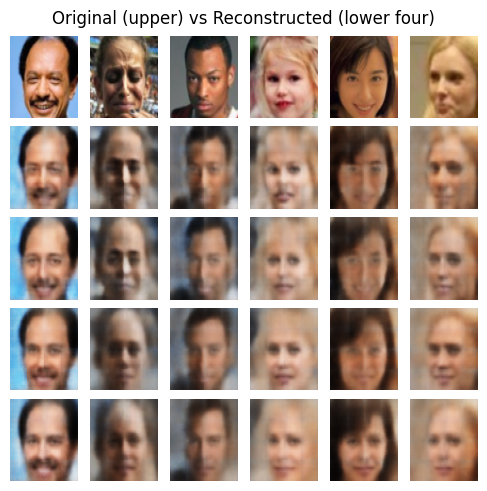

In [16]:
fig, axes = plt.subplots(5, 6, constrained_layout=True, figsize=plt.figaspect(1))
for row, (name, recon) in enumerate(recons.items()):
    for col in range(6):
        axes[row, col].imshow(recon[col], aspect=218 / 178)
        axes[row, col].axis("off")

fig.suptitle("Original (upper) vs Reconstructed (lower four)")
fig.show()
plt.savefig("data/vae/plots/celeba_recon_montage.pdf")

Plot each row as a separate figure and then save them with meaningful filenames

/tmp/ipykernel_5857/1777402332.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


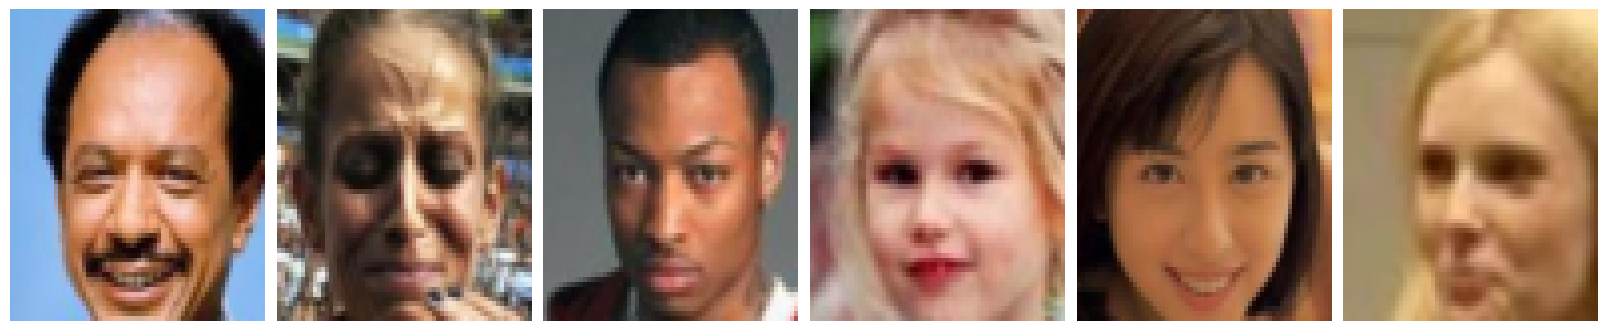

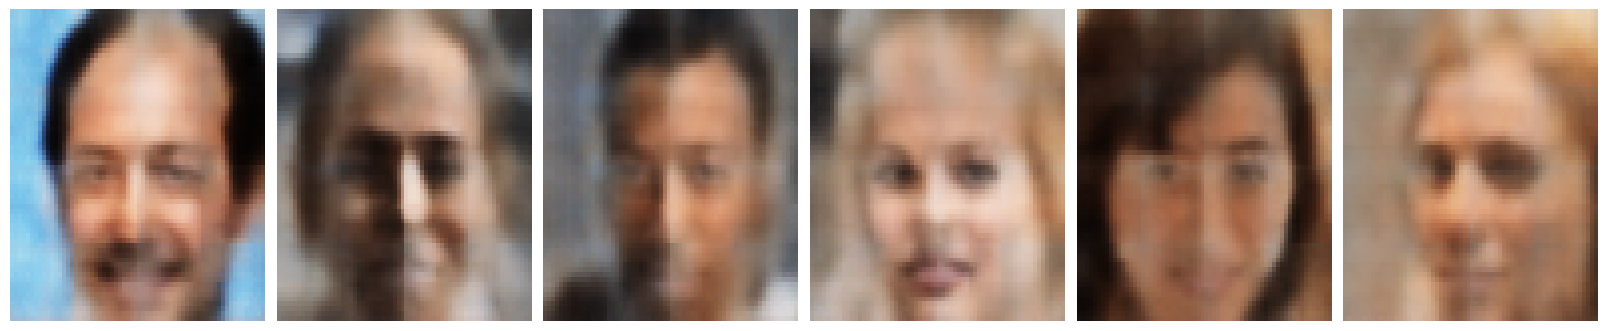

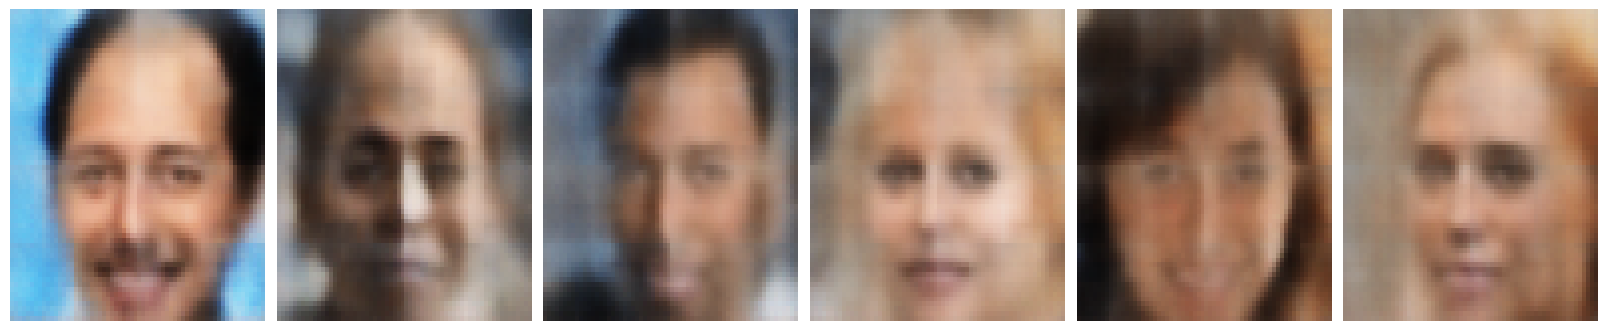

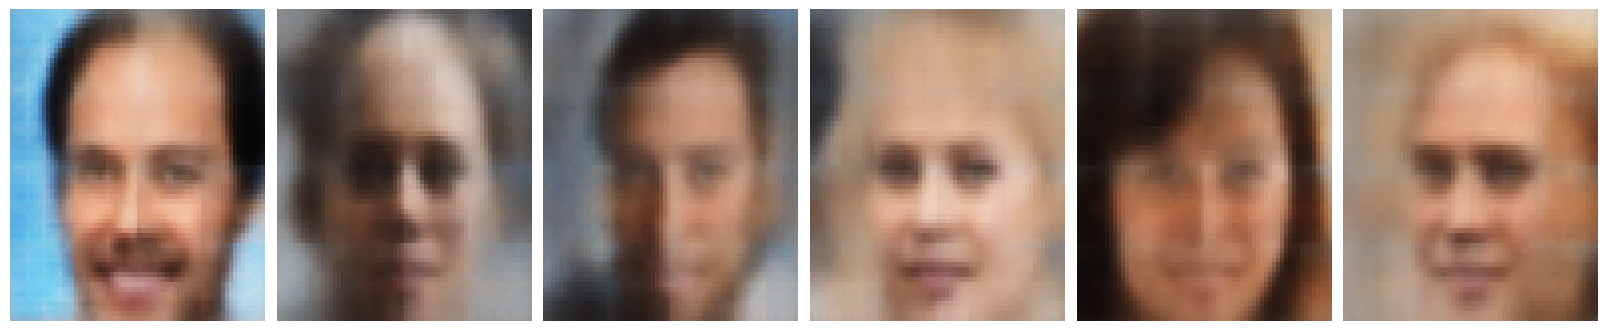

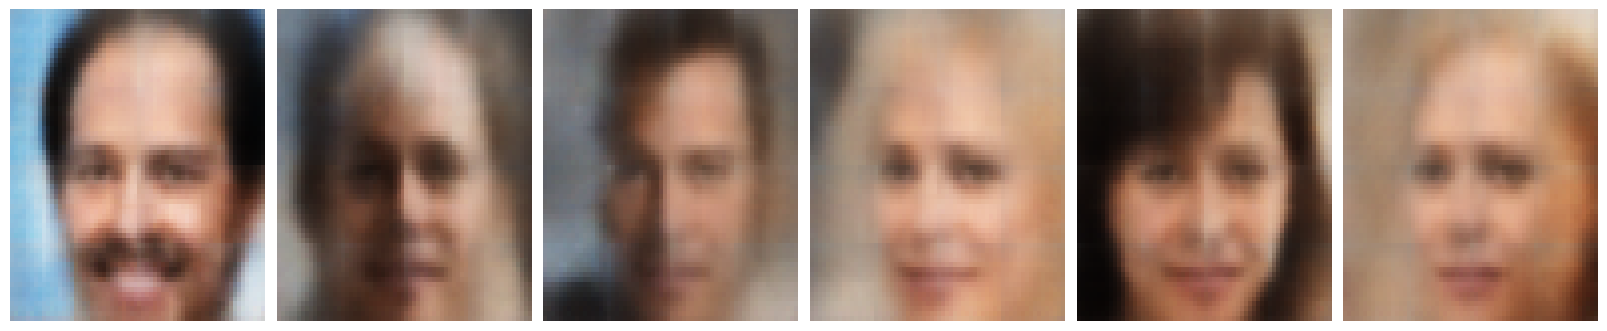

In [17]:
for name, recon in recons.items():
    fig, axes = plt.subplots(1, 6, constrained_layout=True, figsize=plt.figaspect(0.2))
    for col in range(6):
        axes[col].imshow(recon[col], aspect=218 / 178)
        axes[col].axis("off")

    fig.show()

## Sampling

In [18]:
key = jax.random.PRNGKey(42)
key, *key_Z = jax.random.split(key, 5)

generated_images = {}
for i, name in enumerate(configs):
    Z = jax.random.normal(key_Z[i], (8, latent_dim))
    generated_image = decode(states[name], Z)
    generated_images[name] = generated_image

Show a single figure montage

/tmp/ipykernel_5857/3731473455.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


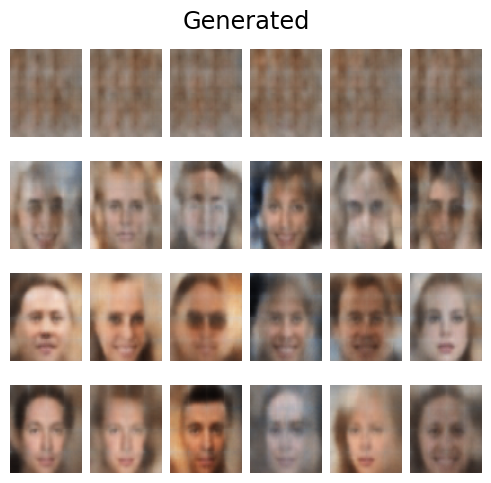

In [19]:
fig, axes = plt.subplots(4, 6, constrained_layout=True, figsize=plt.figaspect(1))
for row, (name, generated_image) in enumerate(generated_images.items()):
    for col in range(6):
        axes[row, col].imshow(generated_image[col], aspect=218 / 178)
        axes[row, col].axis("off")

fig.suptitle("Generated", fontsize="xx-large")
fig.show()

Plot each row as a separate figure and then save them with meaningful filenames

/tmp/ipykernel_5857/3631825661.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


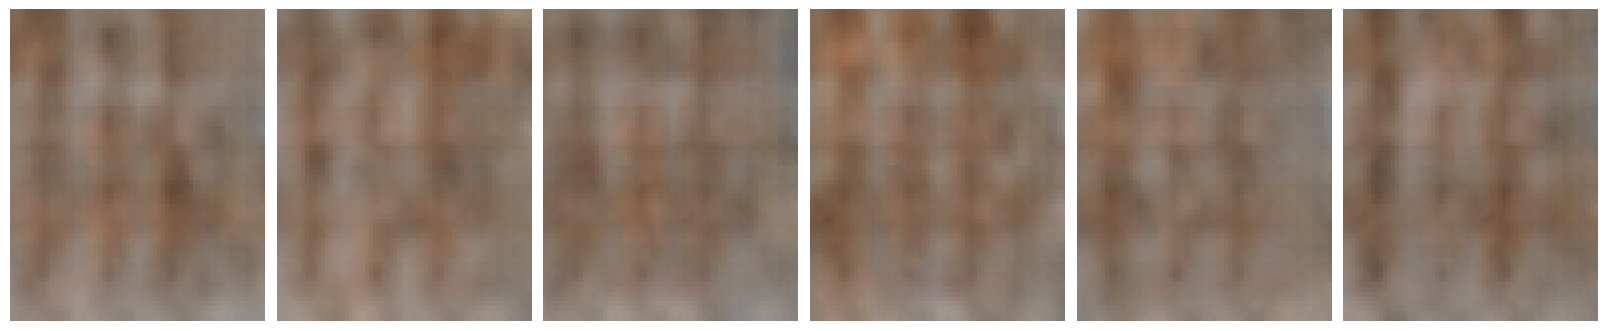

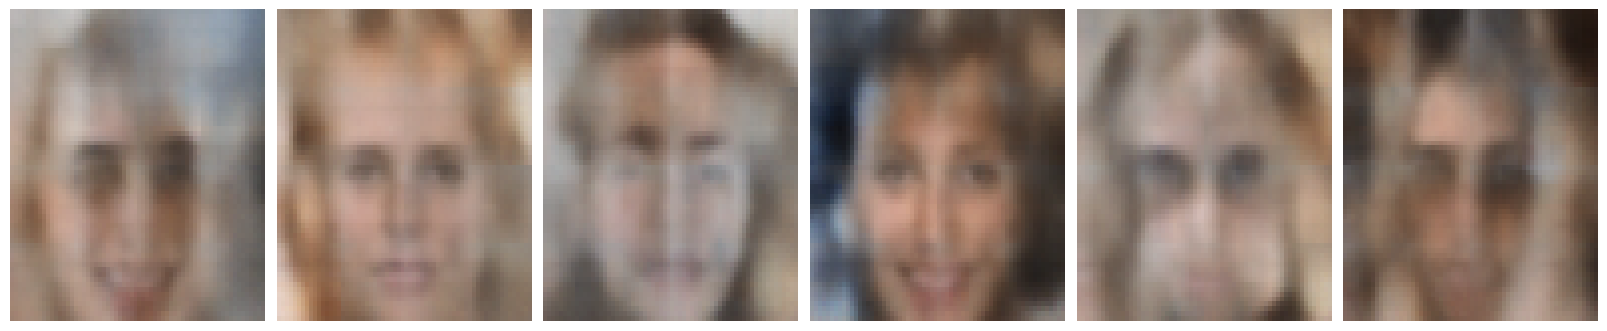

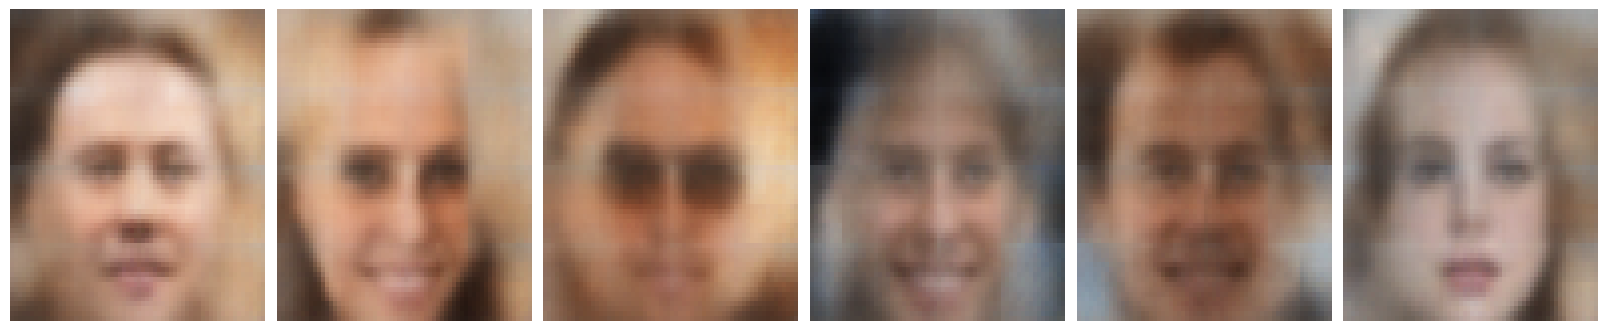

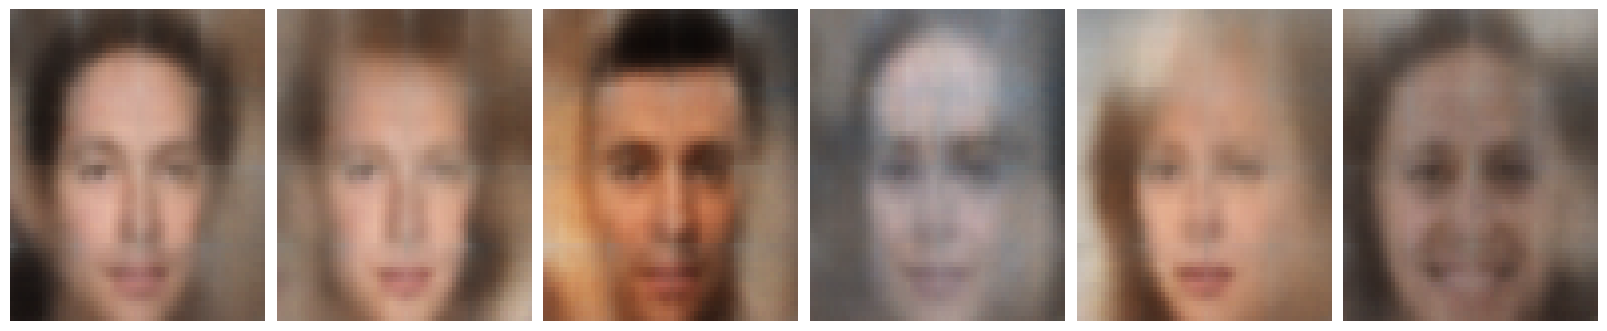

In [20]:
for name, generated_image in generated_images.items():
    fig, axes = plt.subplots(1, 6, constrained_layout=True, figsize=plt.figaspect(0.2))
    for col in range(6):
        axes[col].imshow(generated_image[col], aspect=218 / 178)
        axes[col].axis("off")

    fig.show()

## Interpolation

In [21]:
X, y = next(iter(loader_test))
image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0

means = {}
key = jax.random.PRNGKey(42)
key, *key_Z = jax.random.split(key, 5)
for i, name in enumerate(configs):
    _, mean, _ = test_step(states[name], key_Z[i], image)
    means[name] = mean, image

Show interpolation results

In [22]:
def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    elif jnp.allclose(low, high):
        return low
    omega = jnp.arccos(jnp.dot(low / jnp.linalg.norm(low), high / jnp.linalg.norm(high)))
    so = jnp.sin(omega)
    return jnp.sin((1.0 - val) * omega) / so * low + jnp.sin(val * omega) / so * high


def interp(start_index, end_index):
    for name, (mean, image) in means.items():
        fig, axes = plt.subplots(1, 6, constrained_layout=True, figsize=plt.figaspect(0.2))

        # Anchors
        axes[0].imshow(image[start_index], aspect=218 / 178)
        axes[0].set_title("Start Image")
        axes[0].axis("off")
        axes[5].imshow(image[end_index], aspect=218 / 178)
        axes[5].set_title("End Image")
        axes[5].axis("off")

        # Interpolated images
        for col in range(1, 5):
            Z = slerp(col / 5, mean[start_index], mean[end_index])
            recon = decode(states[name], Z)
            axes[col].imshow(recon[0], aspect=218 / 178)
            axes[col].set_title(f"{col/5}")
            axes[col].axis("off")

        fig.show()
        plt.savefig(f"data/vae/plots/celeba_interp_start{start_index}_end{end_index}_{name}.pdf")

/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


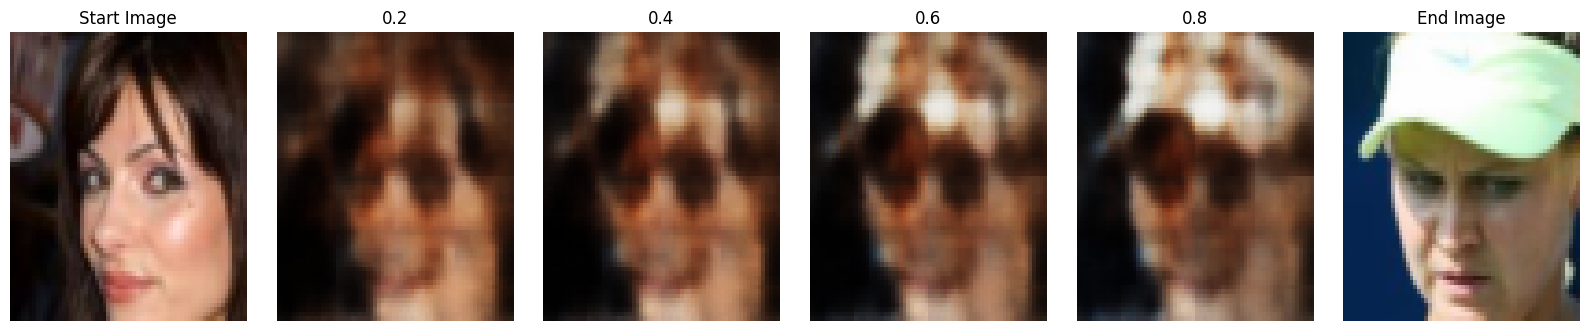

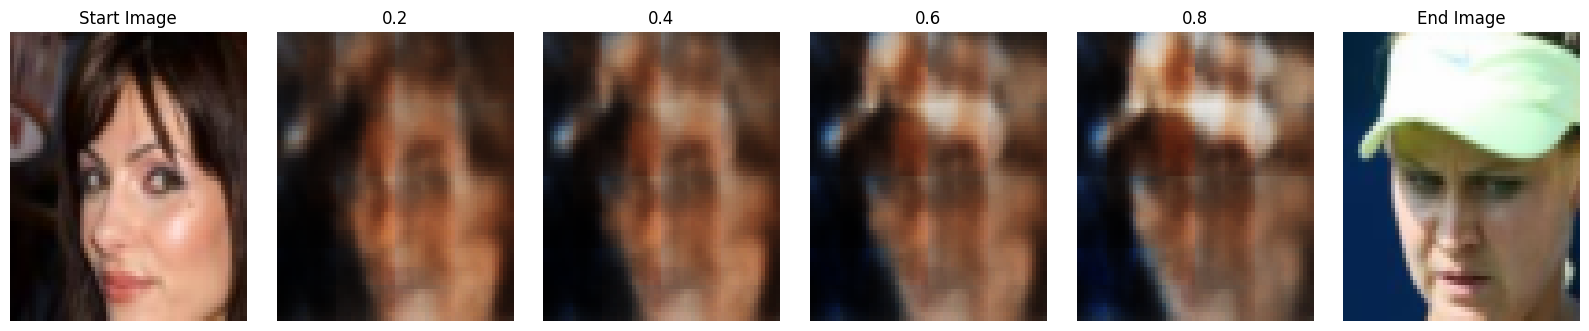

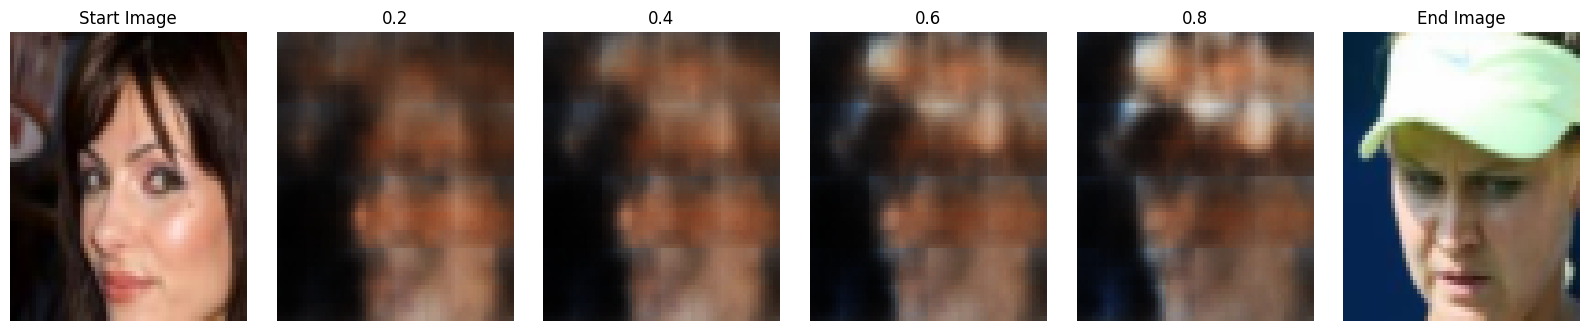

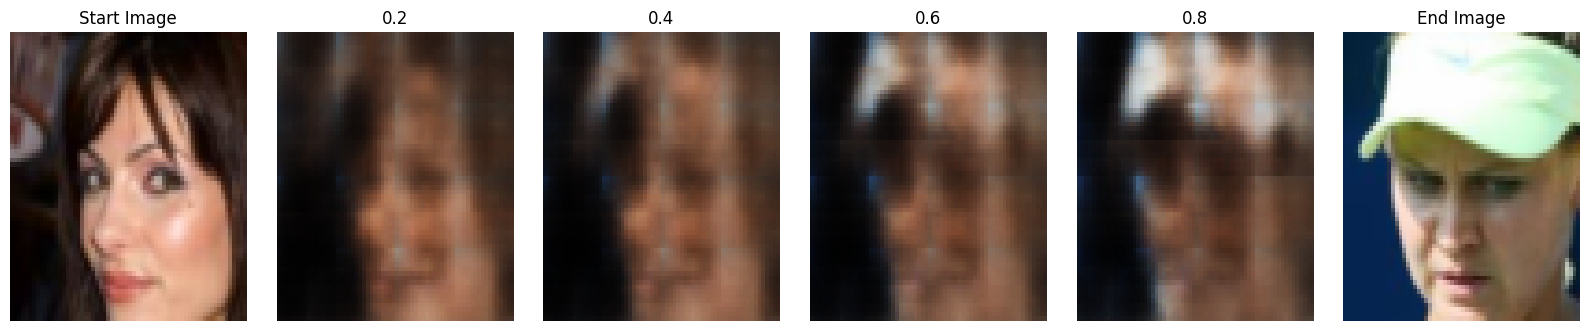

In [23]:
interp(0, 1)

/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


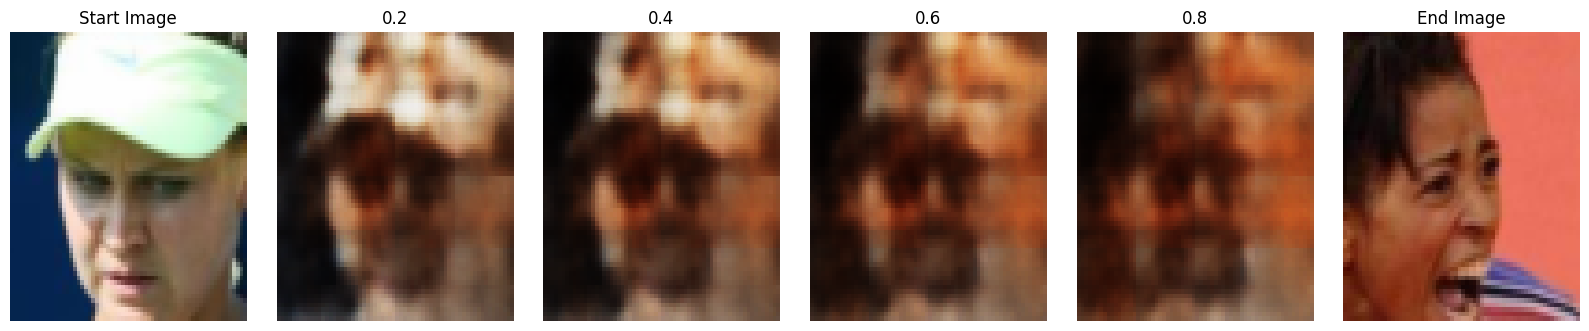

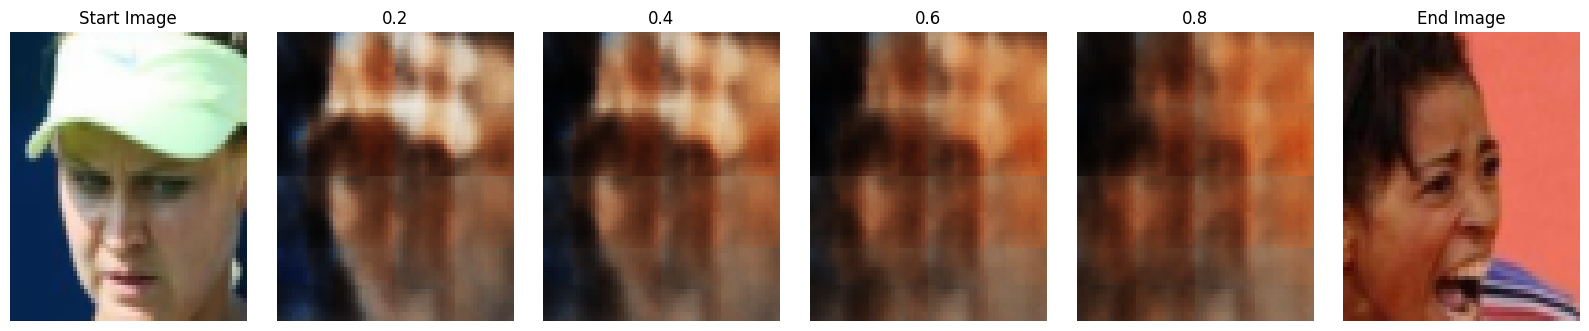

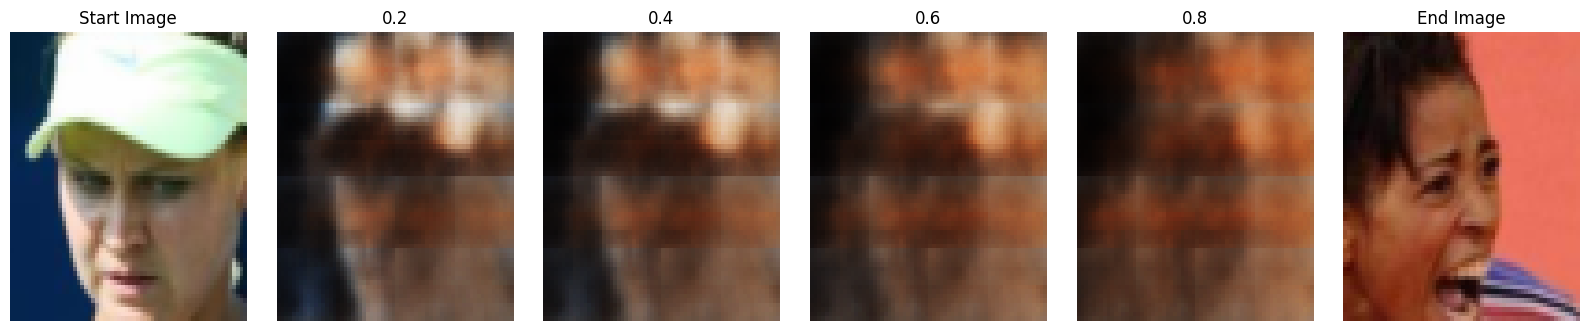

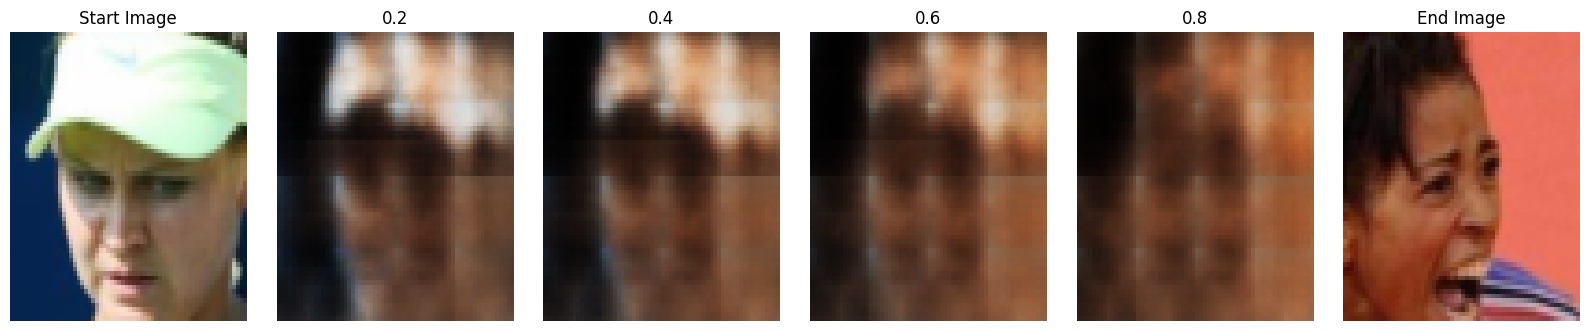

In [24]:
interp(1, 2)

/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/1662288838.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


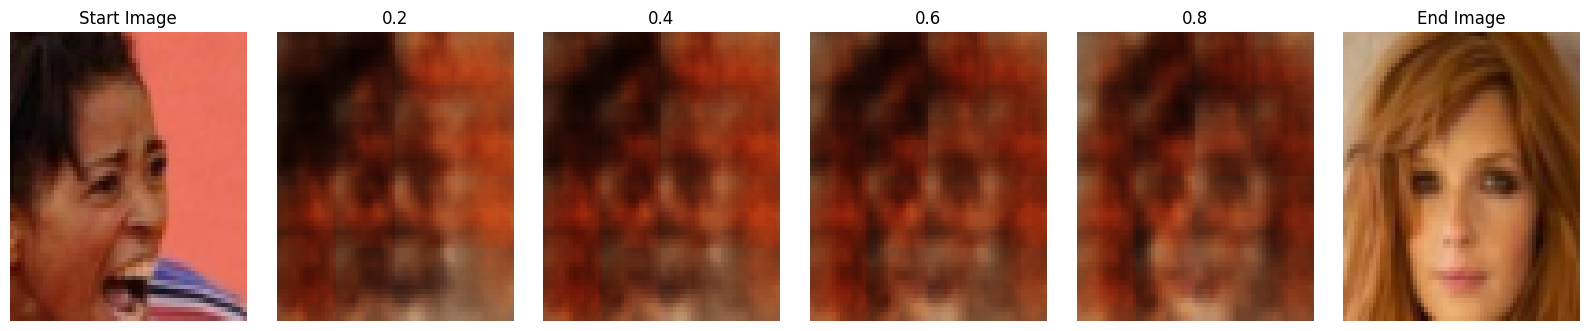

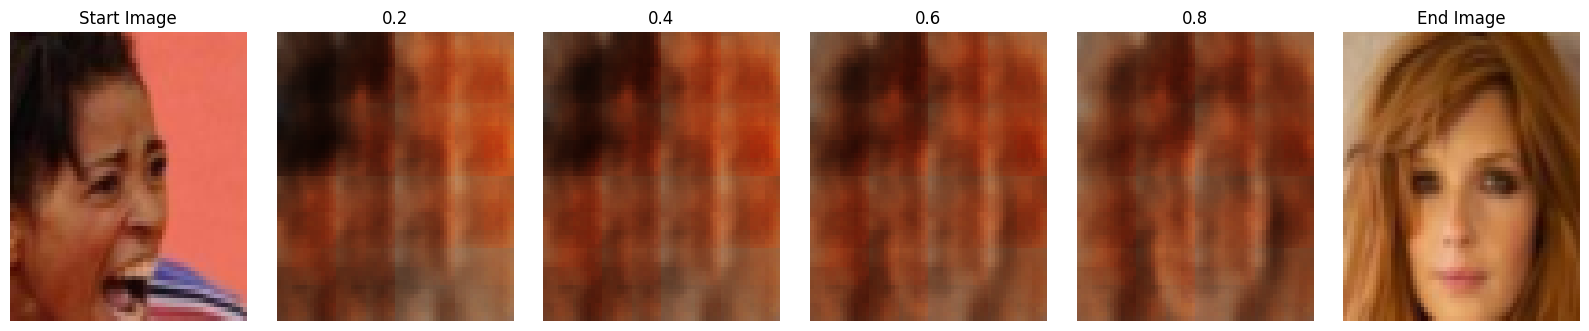

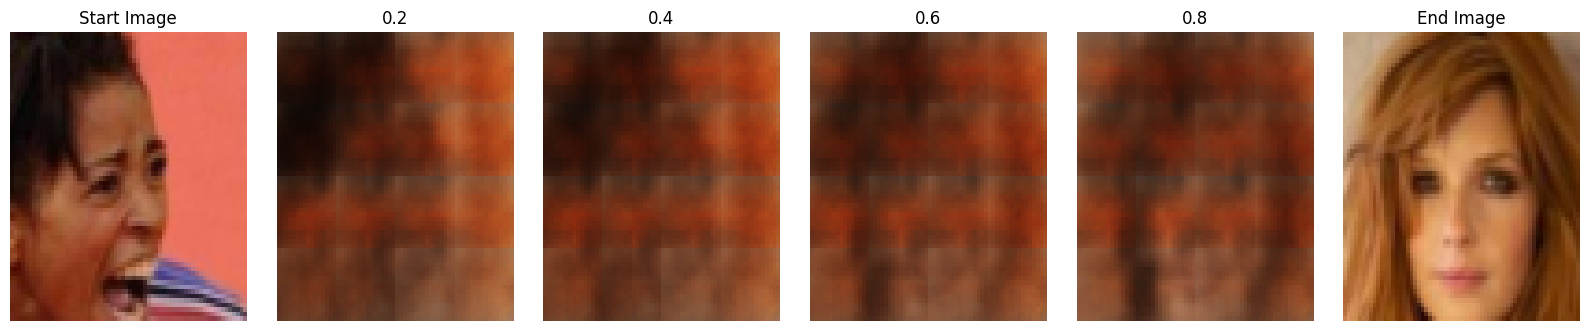

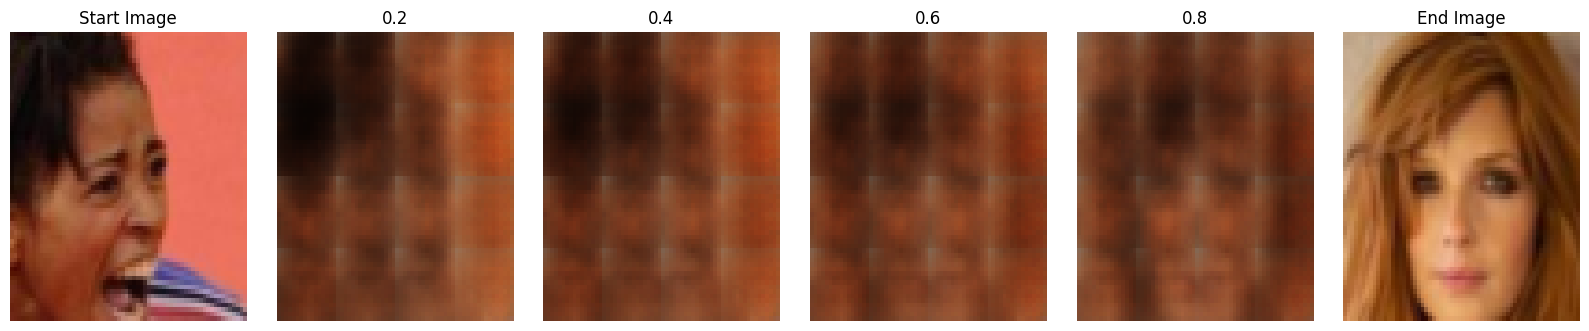

In [25]:
interp(2, 3)

## Vector Arithmetic

Calculate the latent vector corresponding to whether the subject is wearing eyeglasses.

In [26]:
eyeglasses_delta = {}
for name in configs:
    eyeglasses_delta[name] = (jnp.zeros((latent_dim,)), jnp.zeros((latent_dim,)), 0, 0)

eyeglasses_attr_idx = 15
key = jax.random.PRNGKey(42)
for X, y in loader_test:
    image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0
    key, *key_Z = jax.random.split(key, 5)
    for i, name in enumerate(configs):
        _, mean, _ = test_step(states[name], key_Z[i], image)
        sum_pos, sum_neg, count_pos, count_neg = eyeglasses_delta[name]
        eyeglass_mask = jnp.array(y[:, eyeglasses_attr_idx] == 1)
        sum_pos += mean[eyeglass_mask, :].sum(axis=0)
        sum_neg += mean[~eyeglass_mask, :].sum(axis=0)
        count_pos += eyeglass_mask.sum()
        count_neg += (~eyeglass_mask).sum()
        eyeglasses_delta[name] = sum_pos, sum_neg, count_pos, count_neg

In [27]:
X, y = next(iter(loader_test))
image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0

va_means = {}
key = jax.random.PRNGKey(42)
key, *key_Z = jax.random.split(key, 5)
for i, name in enumerate(configs):
    _, mean, _ = test_step(states[name], key_Z[i], image)
    va_means[name] = mean, image

Show a single figure montage

In [28]:
def arith_montage(image_index, multiplier):
    fig, axes = plt.subplots(4, 6, constrained_layout=True, figsize=plt.figaspect(1))
    for row, (name, (sum_pos, sum_neg, count_pos, count_neg)) in enumerate(eyeglasses_delta.items()):
        delta = sum_pos / count_pos - sum_neg / count_neg
        mean, image = va_means[name]
        axes[row, 0].set_title("Original")
        axes[row, 0].axis("off")
        axes[row, 0].imshow(image[image_index], aspect=218 / 178)
        for col in range(1, 6):
            coef = multiplier * (col - 3)
            Z = mean[image_index] + coef * delta
            recon = decode(states[name], Z)
            axes[row, col].set_title(f"{coef}")
            axes[row, col].axis("off")
            axes[row, col].imshow(recon[0], aspect=218 / 178)

    fig.show()
    plt.savefig(f"data/vae/plots/celeba_arith_img{image_index}_mul{multiplier}_montage.pdf")

/tmp/ipykernel_5857/899814971.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


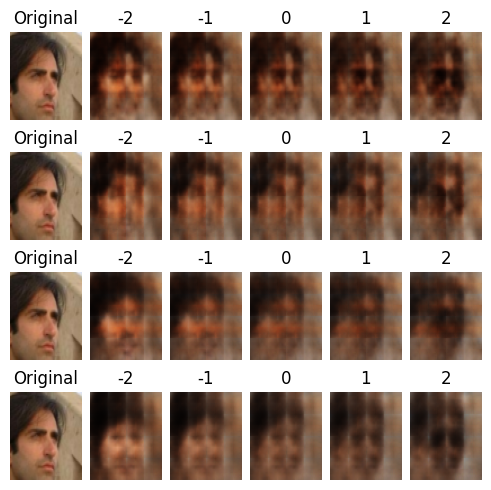

In [29]:
arith_montage(0, 1)

/tmp/ipykernel_5857/899814971.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


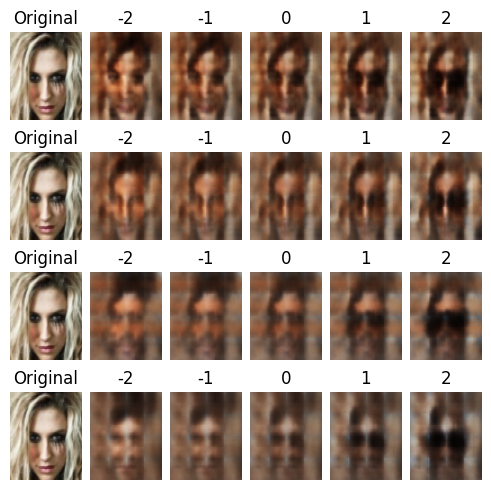

In [30]:
arith_montage(1, 1)

/tmp/ipykernel_5857/899814971.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


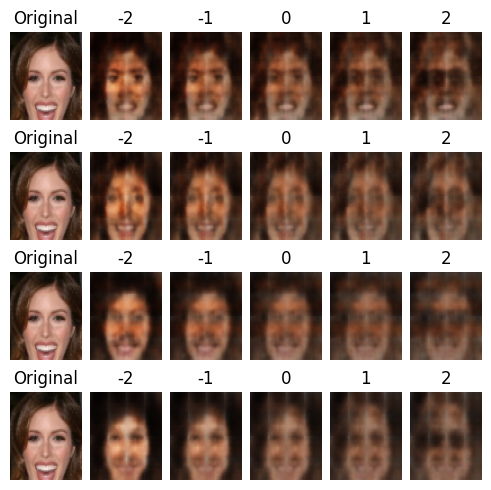

In [31]:
arith_montage(2, 1)

/tmp/ipykernel_5857/899814971.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


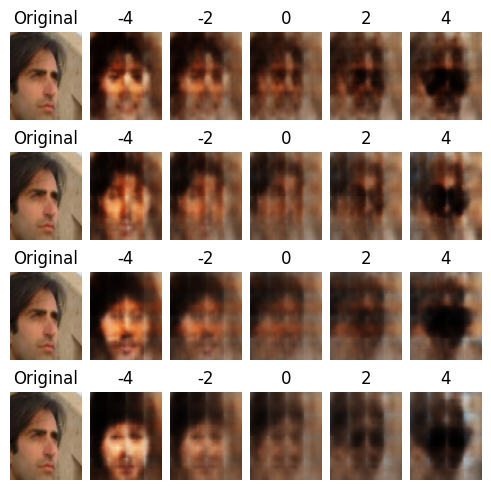

In [32]:
arith_montage(0, 2)

/tmp/ipykernel_5857/899814971.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


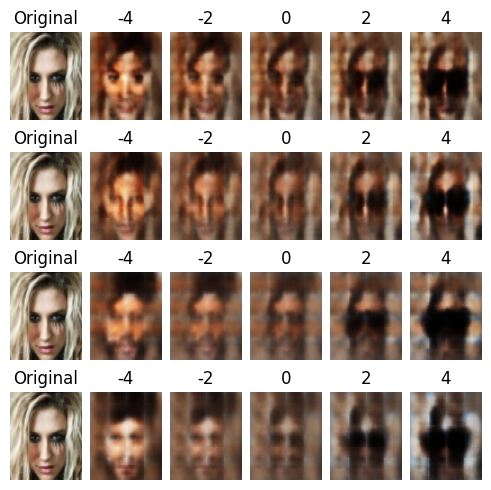

In [33]:
arith_montage(1, 2)

/tmp/ipykernel_5857/899814971.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


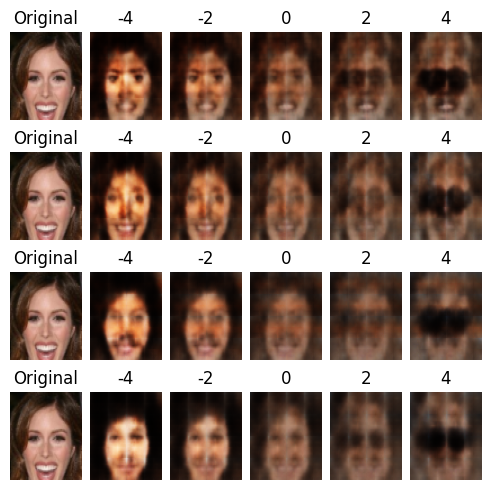

In [34]:
arith_montage(2, 2)

Plot each row as a separate figure and then save them with meaningful filenames

In [35]:
def arith(image_index, multiplier):
    for name, (sum_pos, sum_neg, count_pos, count_neg) in eyeglasses_delta.items():
        fig, axes = plt.subplots(1, 6, constrained_layout=True, figsize=plt.figaspect(0.2))
        delta = sum_pos / count_pos - sum_neg / count_neg
        mean, image = va_means[name]
        axes[0].set_title("Original")
        axes[0].axis("off")
        axes[0].imshow(image[image_index], aspect=218 / 178)
        for col in range(1, 6):
            coef = multiplier * (col - 3)
            Z = mean[image_index] + coef * delta
            recon = decode(states[name], Z)
            axes[col].set_title(f"{coef}")
            axes[col].axis("off")
            axes[col].imshow(recon[0], aspect=218 / 178)

        fig.show()
        plt.savefig(f"data/vae/plots/celeba_arith_img{image_index}_mul{multiplier}_{name}.pdf")

/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


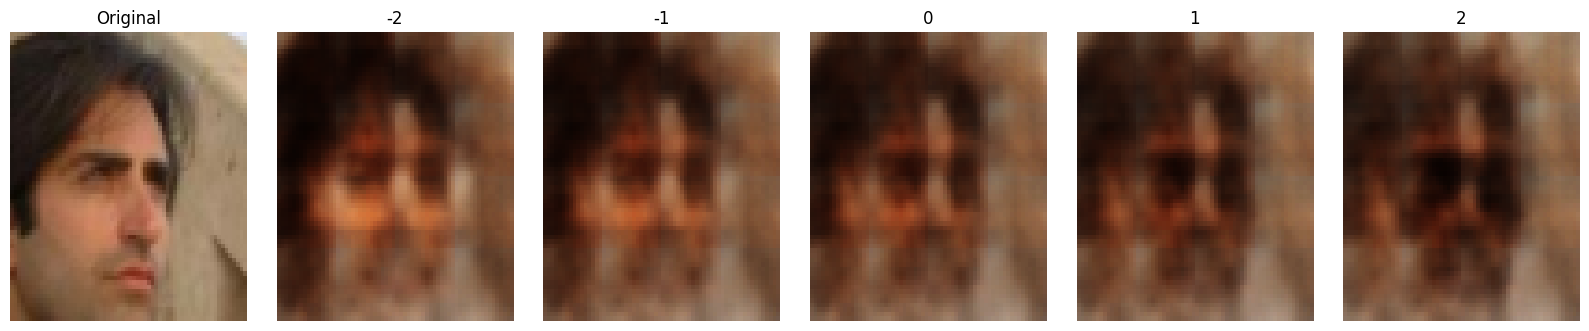

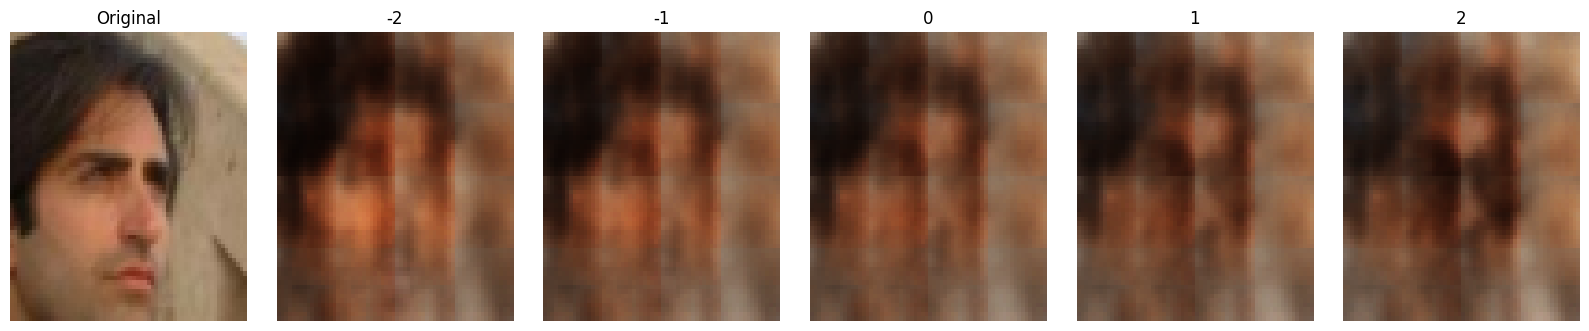

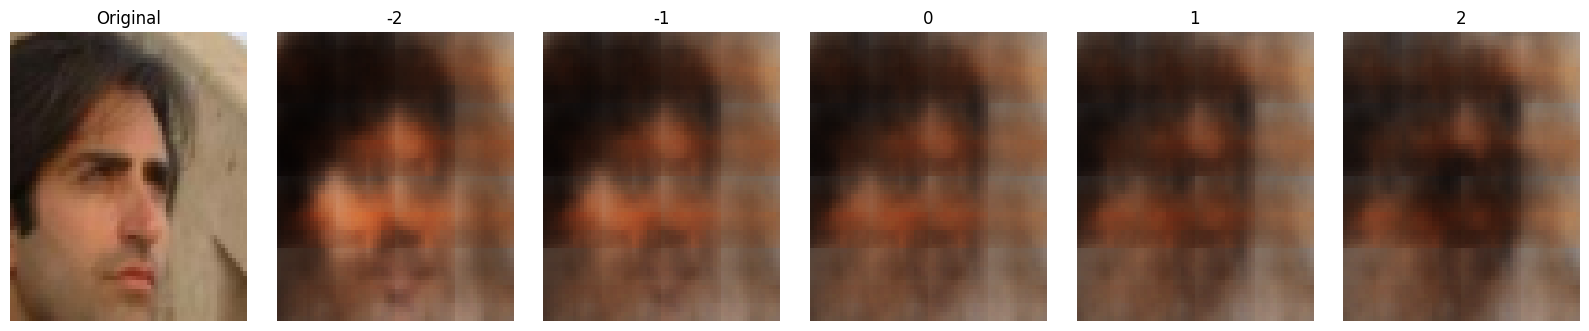

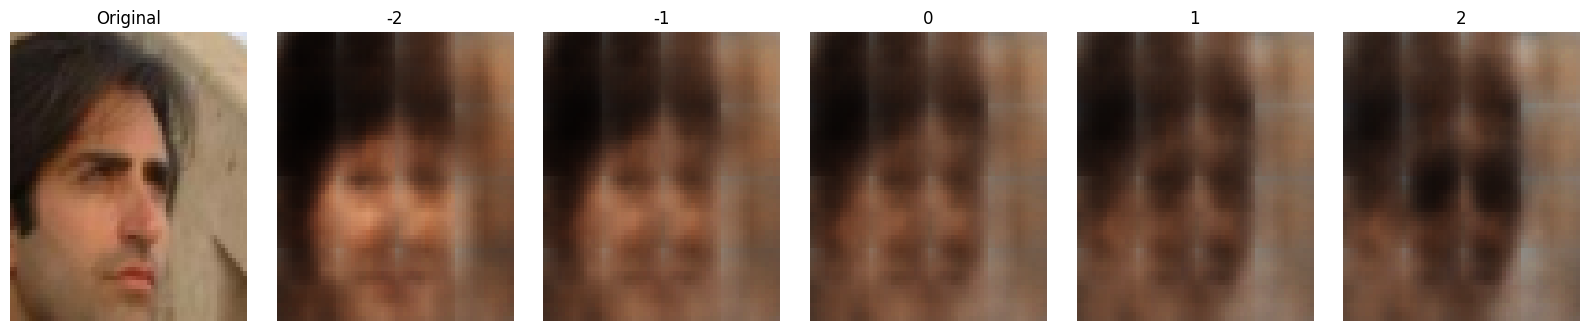

In [36]:
arith(0, 1)

/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


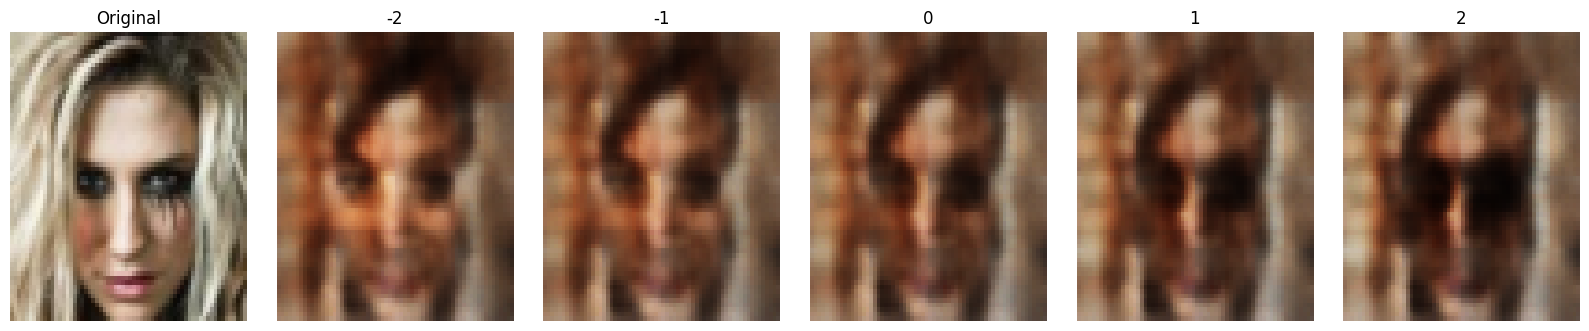

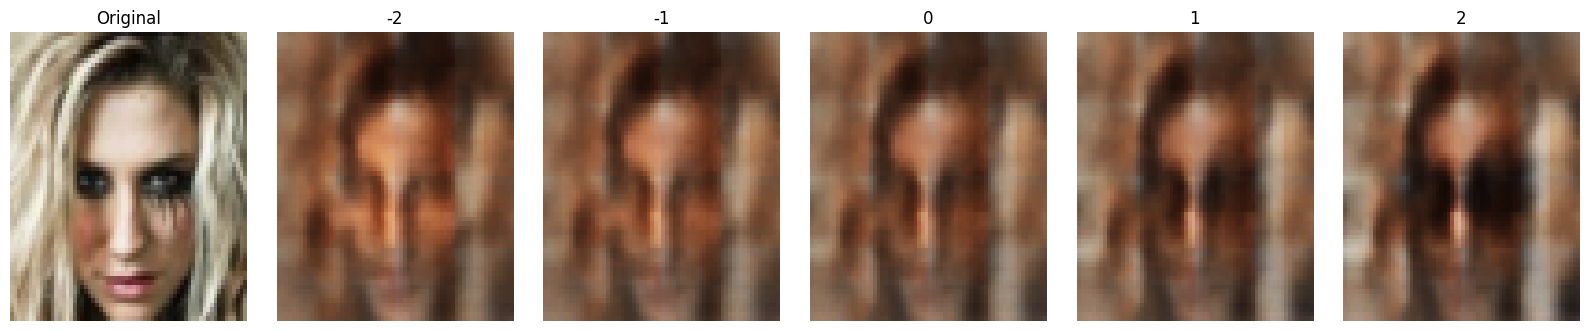

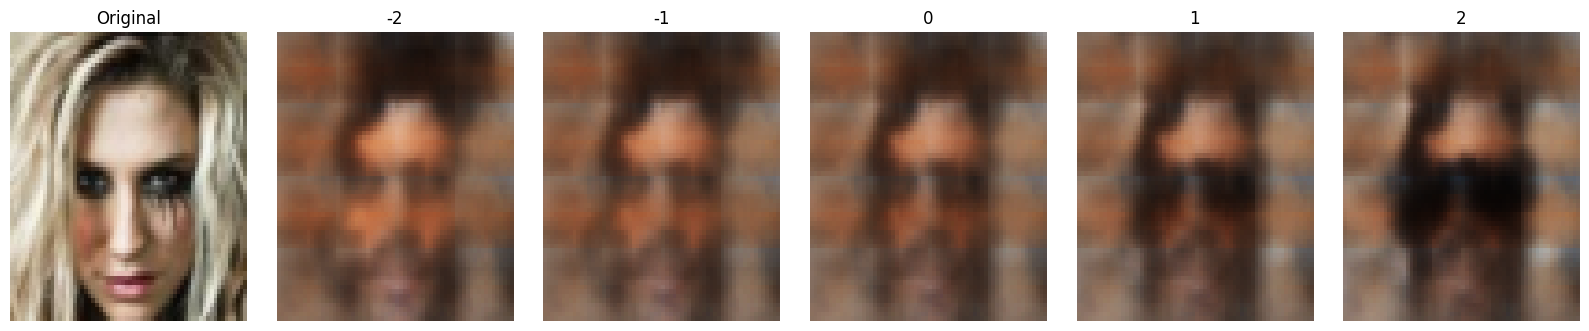

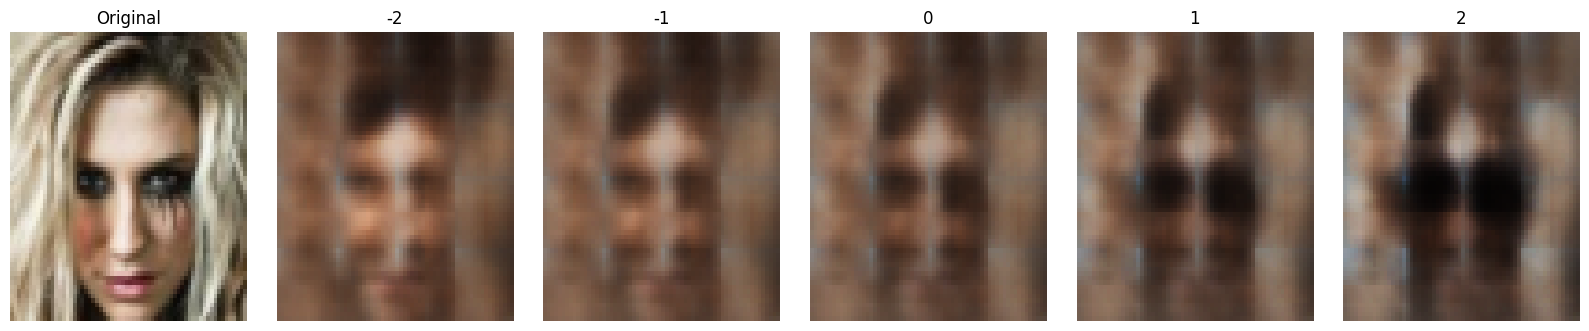

In [37]:
arith(1, 1)

/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


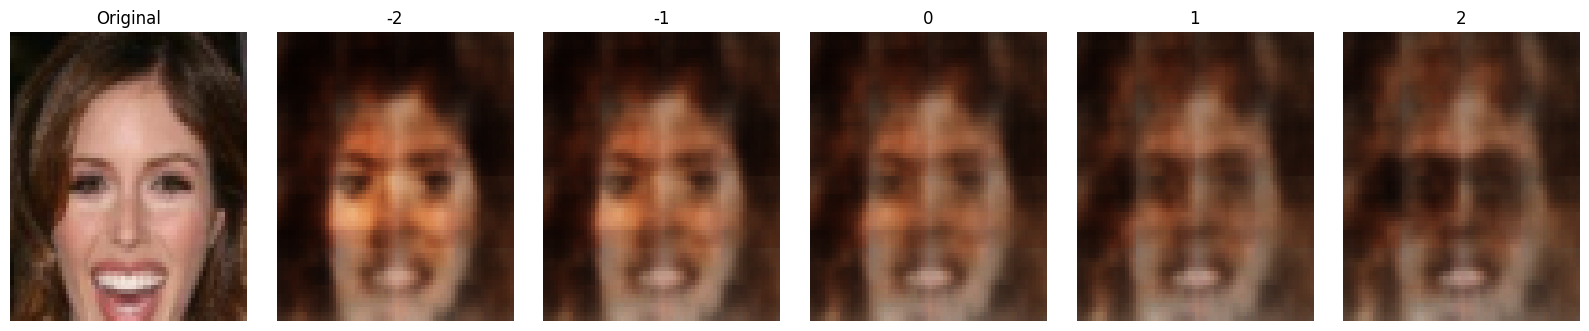

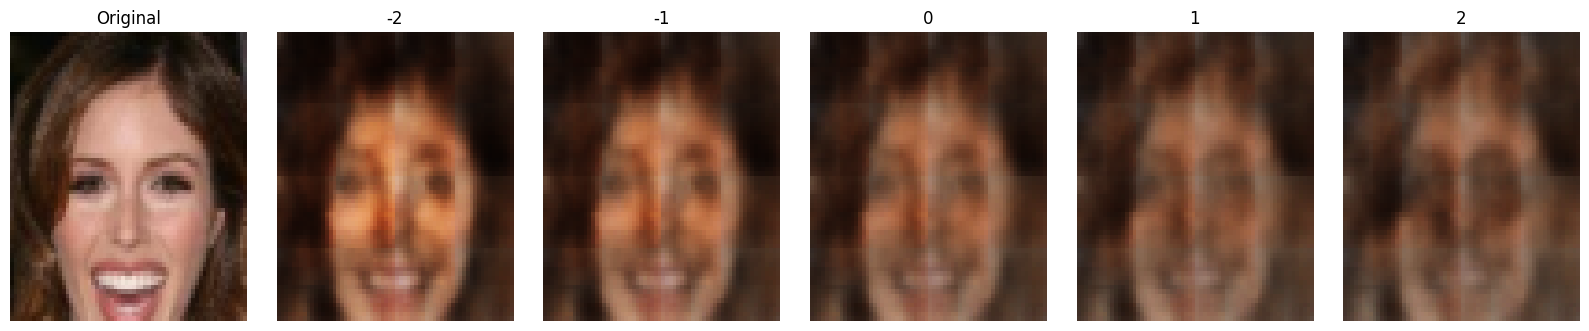

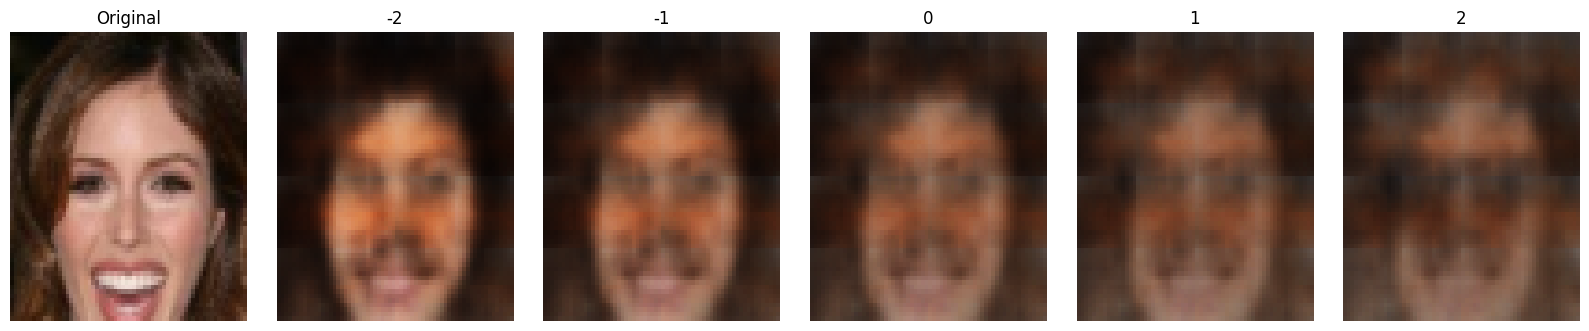

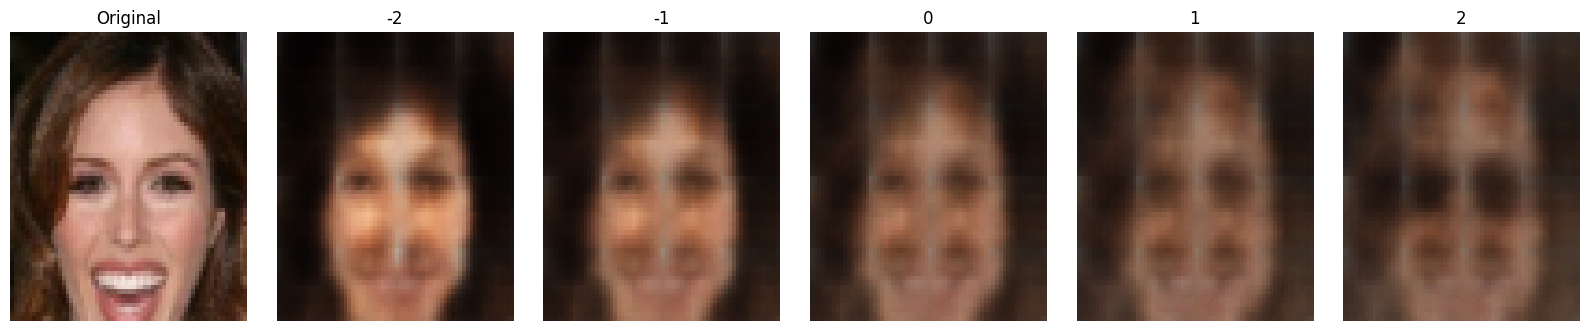

In [38]:
arith(2, 1)

/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


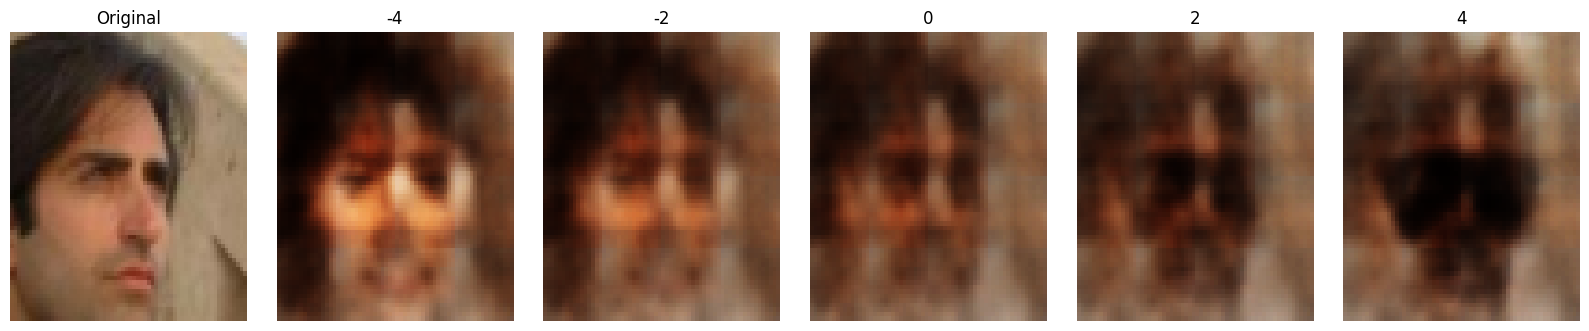

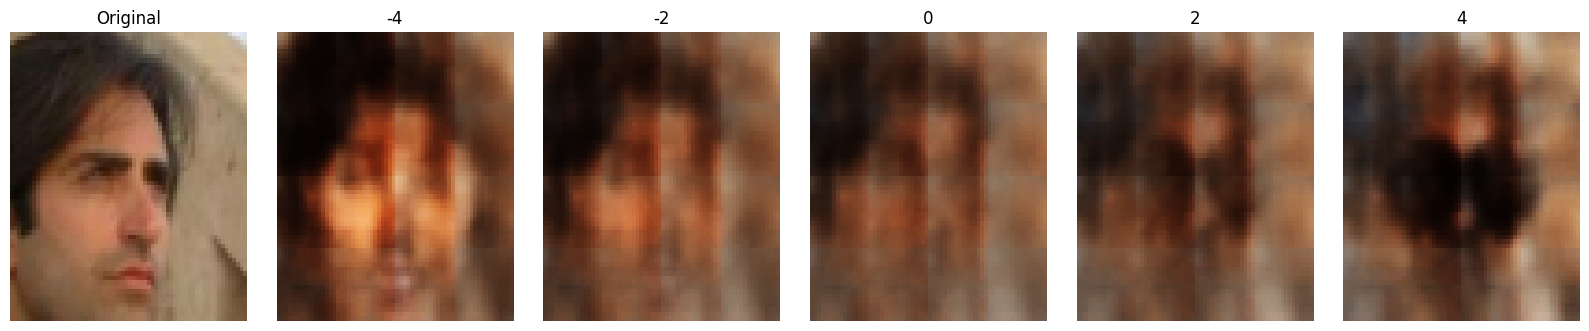

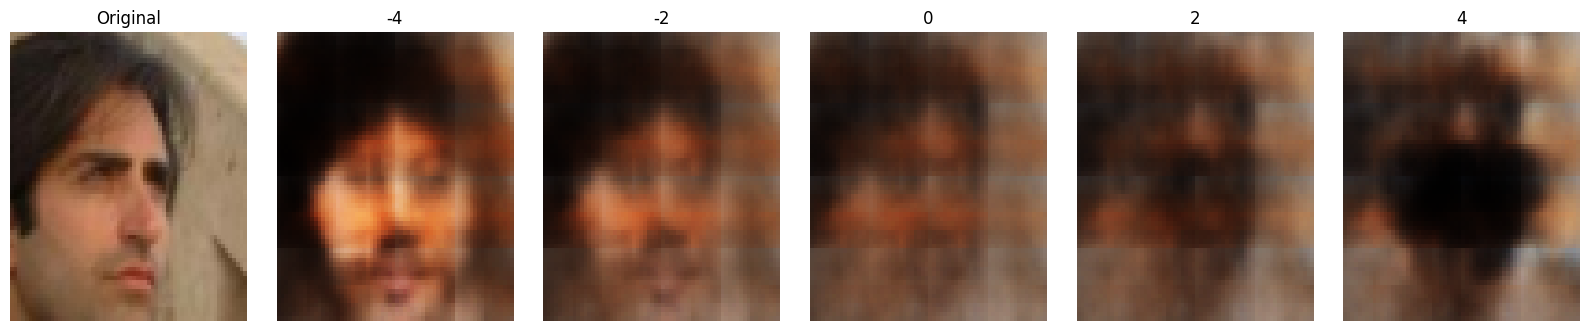

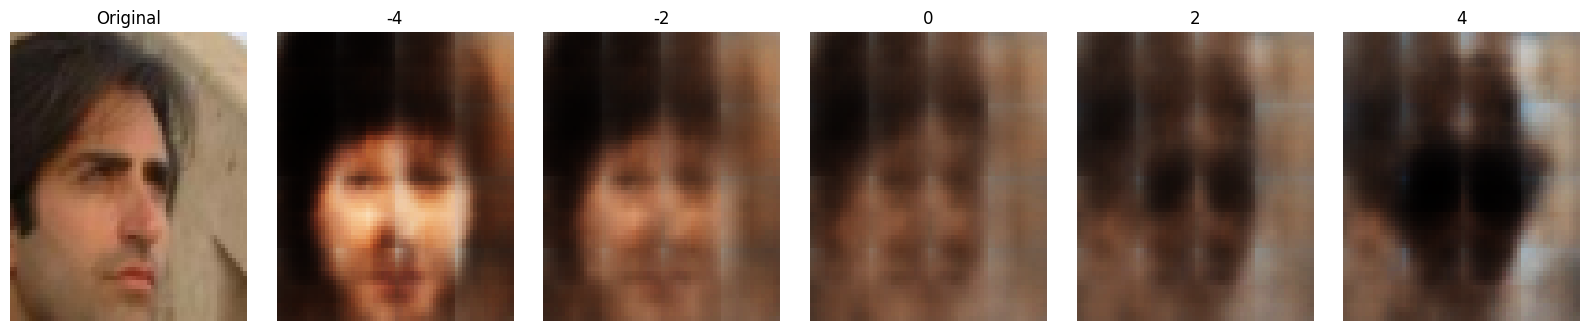

In [39]:
arith(0, 2)

/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


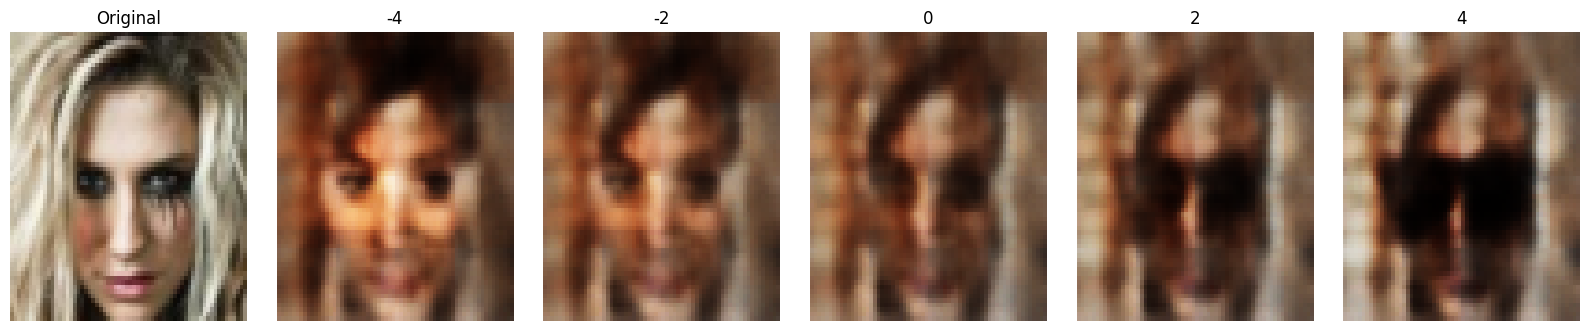

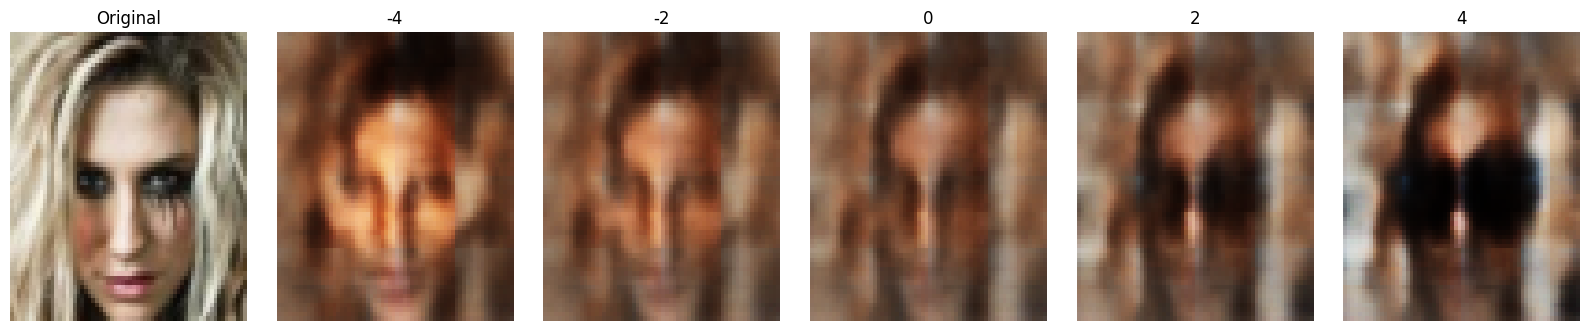

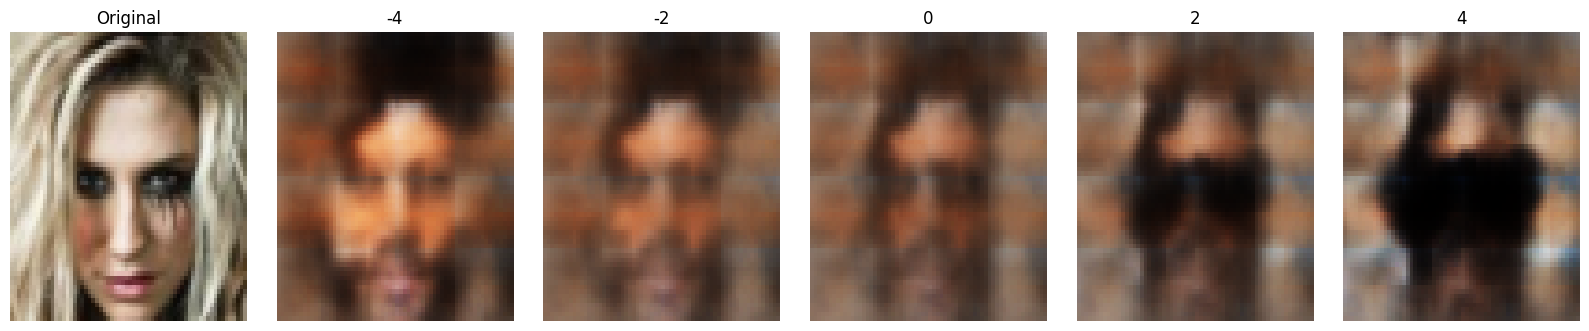

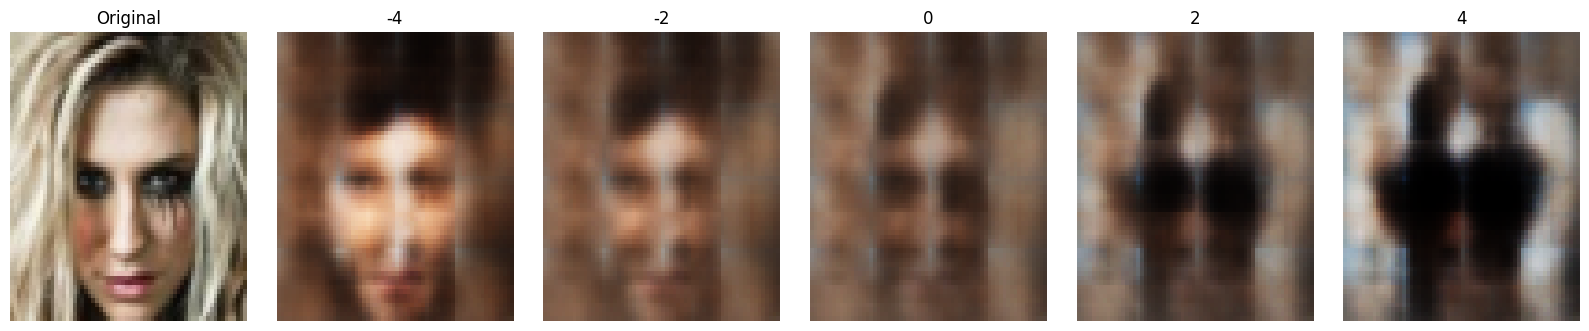

In [40]:
arith(1, 2)

/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_5857/2157693327.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


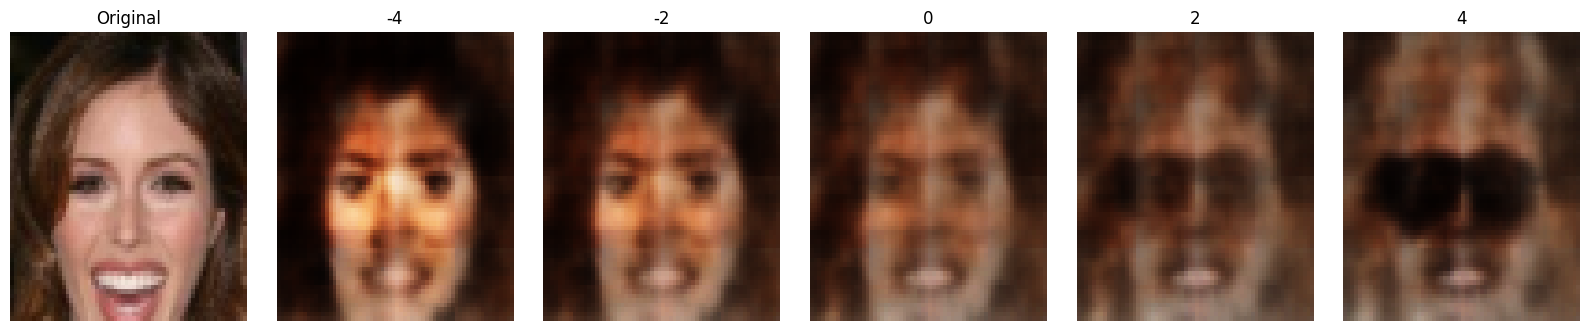

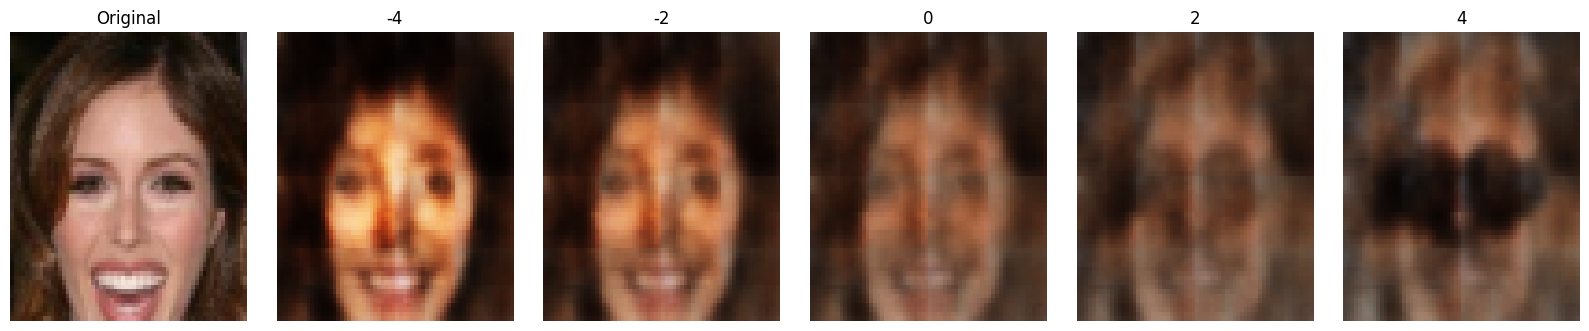

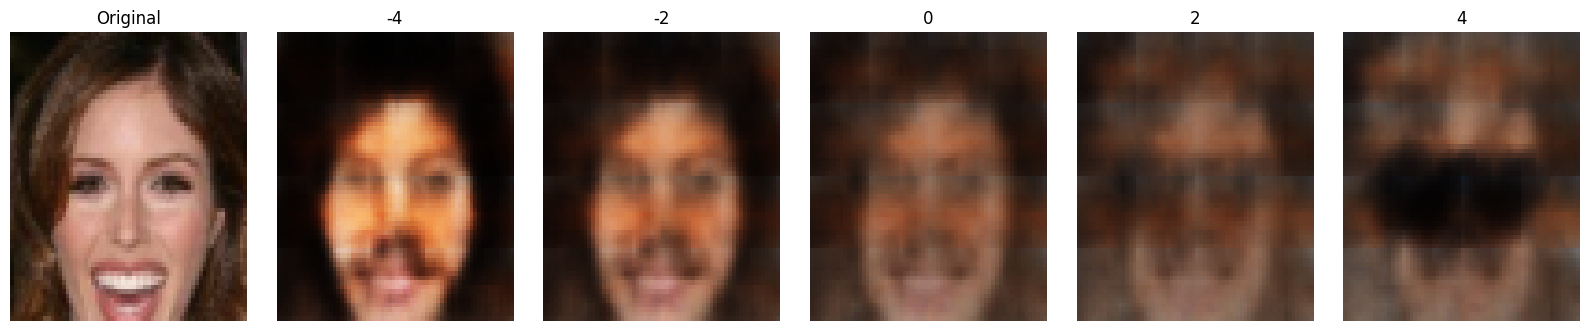

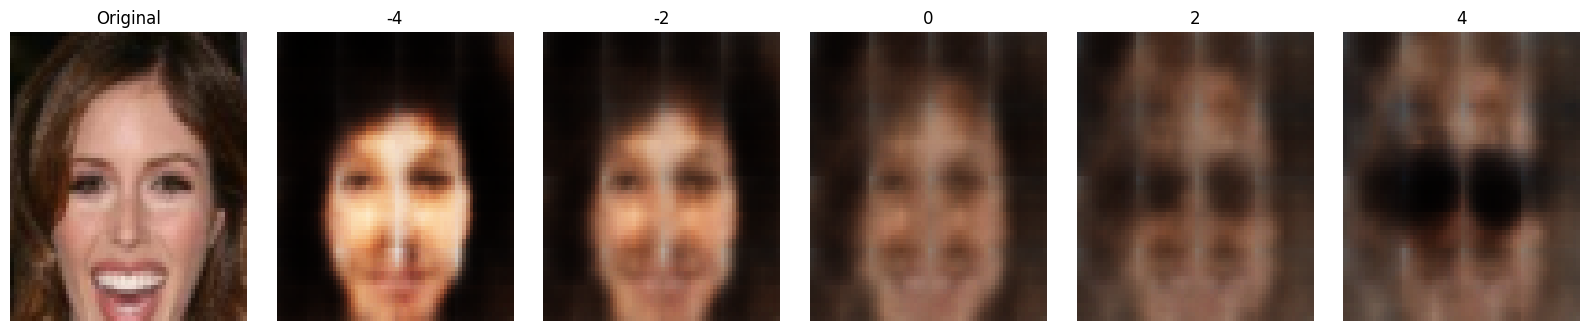

In [41]:
arith(2, 2)